In [58]:
#Import Statements
import os, itertools
import warnings
from matplotlib.pyplot import text
from numpy import vectorize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
import re
import numpy as np
import warnings
import statistics
import math
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from JaccardIndexUpdated import JaccardIndex, ClustersData, summary
from sklearn.decomposition import TruncatedSVD
from CleanText import getCleanText, getDataFrame
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score




In [57]:

import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
from django.urls import re_path as url
import holoviews as hv
import holoviews.operation.datashader as hd 
import umap
import umap.plot
import hdbscan

c:\Users\Public\Anaconda\lib\site-packages\umap\plot.py:66: UserWarning: Trying to register the cmap 'fire' which already exists.
  plt.register_cmap("fire", fire_cmap)


In [83]:
text_l, types_l = getCleanText('CleanAllTexts')
maxFreq = .8
minFreq = .005
ngramRange = (1,4)
tfidfvectorizer = TfidfVectorizer(stop_words= 'english', lowercase = True, max_df = maxFreq, min_df = minFreq, ngram_range=ngramRange)
tfidf_wm = tfidfvectorizer.fit_transform(text_l)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()

df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = types_l,columns = tfidf_tokens)

neigbors = 5
dist = 0.3

umapVectorizer = umap.UMAP(metric = 'cosine')
#umapVectorizer = umap.UMAP(n_neighbors= neigbors, min_dist = dist, metric = 'cosine')
reduceTokensUMAP = umapVectorizer.fit(df_tfidfvect)
reduceTokens = umapVectorizer.fit_transform(df_tfidfvect)

    

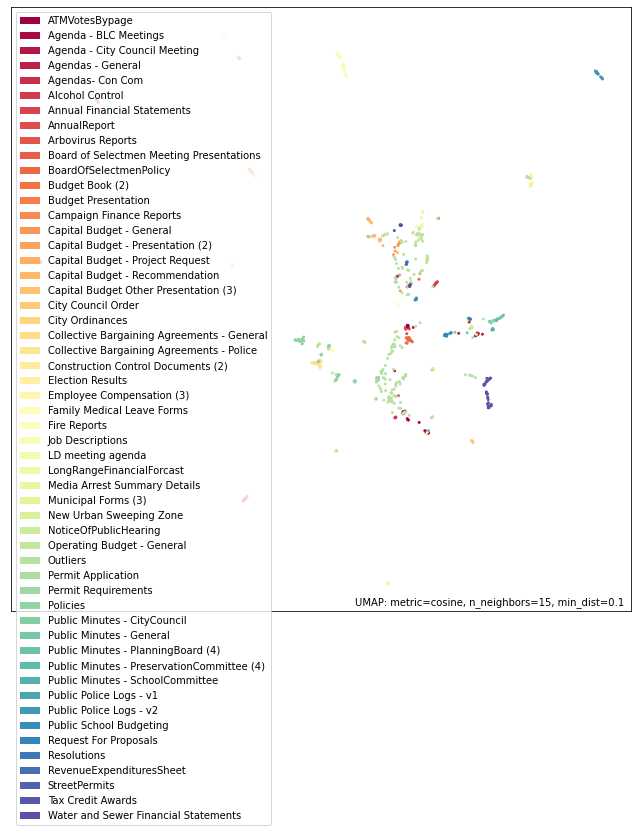

In [65]:
fig = umap.plot.points(reduceTokensUMAP, labels = np.array(types_l))
#print(len(reduceTokens))

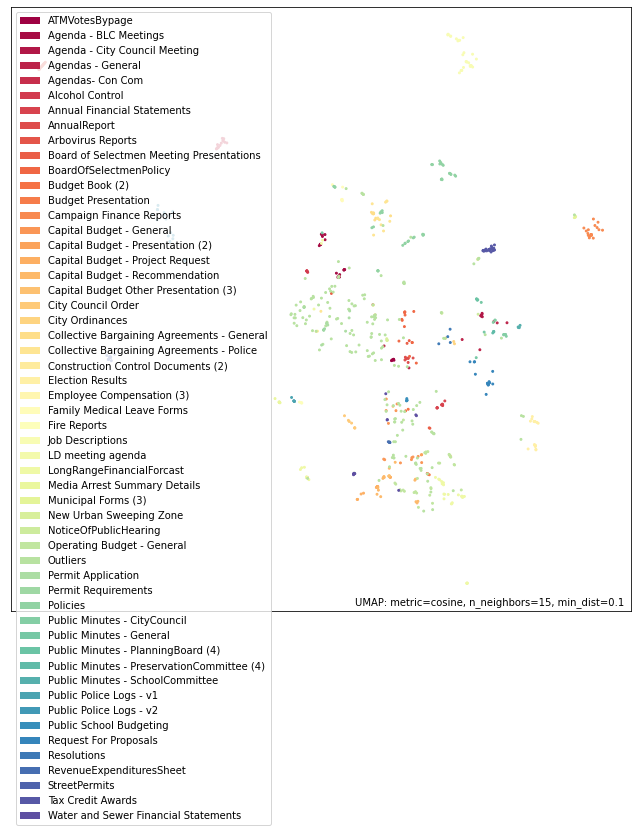

In [69]:
neigbors = 5
dist = 0.3

umapVectorizerCustom = umap.UMAP(n_neighbors= neigbors, min_dist = dist, metric = 'cosine')
#umapVectorizer = umap.UMAP(metric = 'cosine', densmap = True)
reduceTokensUMAPCustom = umapVectorizer.fit(df_tfidfvect)
reduceTokensCustom = umapVectorizer.fit_transform(df_tfidfvect)
figCustom = umap.plot.points(reduceTokensUMAPCustom, labels = np.array(types_l))


In [68]:
import umap.parametric_umap
from umap.parametric_umap import ParametricUMAP

parametricEmbedder = ParametricUMAP()
parametricEmbedding = parametricEmbedder.fit_transform(df_tfidfvect)

Epoch 1/10
323/323 [==============================] - 895s 3s/step - loss: 7.6752
Epoch 2/10
323/323 [==============================] - 485s 2s/step - loss: 7.6752
Epoch 3/10
323/323 [==============================] - 721s 2s/step - loss: 7.6752
Epoch 4/10
323/323 [==============================] - 551s 2s/step - loss: 7.6752
Epoch 5/10
323/323 [==============================] - 725s 2s/step - loss: 7.6752
Epoch 6/10
  3/323 [..............................] - ETA: 7:49 - loss: 7.6753

KeyboardInterrupt: 

In [73]:
#Agglomertaive

clusterer = hdbscan.HDBSCAN(min_cluster_size= 5, min_samples = 2, algorithm = 'best')
clusterer.fit(reduceTokens)

print("Number of clusters:", len(set(clusterer.labels_)))
print("Number of documents:", len(clusterer.labels_))
clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
df = pd.DataFrame(data = clusterDict, index = types_l)
print(df.to_string())


print(homogeneity_score(types_l, clusterer.labels_))
print(completeness_score(types_l, clusterer.labels_))


Number of clusters: 70
Number of documents: 747
                                            Cluster Label  Cluster probabilities
Agenda - BLC Meetings                                  34               0.749080
Agenda - BLC Meetings                                  34               0.334811
Agenda - BLC Meetings                                  34               0.957854
Agenda - BLC Meetings                                  34               0.075430
Agenda - BLC Meetings                                  34               1.000000
Agenda - BLC Meetings                                  49               0.862964
Agenda - BLC Meetings                                  49               1.000000
Agenda - BLC Meetings                                  49               1.000000
Agenda - BLC Meetings                                  49               1.000000
Agenda - BLC Meetings                                  48               1.000000
Agenda - BLC Meetings                                  34    

In [80]:
svd = TruncatedSVD(n_components=500)
SVDtfidfvect = svd.fit_transform(df_tfidfvect)


neigbors = 5
dist = 0.3
comp = 3

listNeighbors = [2, 5, 10, 20, 50, 100, 200]
listDistances = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
listComponents = [2, 5, 10 , 20, 50, 100]
bestHomo = 0
bestComplete = 0
bestHomoParameters = {"Neighbors": 0, "Distance": 0, "Components": 0}
bestCompleteParameters = {"Neighbors": 0, "Distance": 0, "Components": 0}

for n in listNeighbors:
    print("N:", n)
    for d in listDistances:
        print("D:",d)
        for c in listComponents:
            print("C",c)
            umapVectorizer = umap.UMAP(n_neighbors= n, min_dist = d, n_components= c, metric = 'cosine')
            reduceTokens = umapVectorizer.fit_transform(SVDtfidfvect)
            clusterer = hdbscan.HDBSCAN(algorithm = 'best')
            clusterer.fit(reduceTokens)
            clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
            df = pd.DataFrame(data = clusterDict, index = types_l)
            curHomo = homogeneity_score(types_l, clusterer.labels_)
            curComplete = completeness_score(types_l, clusterer.labels_)
            if(curHomo > bestHomo):
                bestHomo = curHomo
                bestHomoParameters["Neighbors"] = n
                bestHomoParameters["Distance"] = d
                bestHomoParameters["Components"] = c
            if(curComplete > bestComplete):
                bestComplete = curComplete
                bestCompleteParameters["Neighbors"] = n
                bestCompleteParameters["Distance"] = d
                bestCompleteParameters["Components"] = c
            print("Current Homo", curHomo)
            print("Current Complete", curComplete)

print("Best Homo", bestHomo)
print(bestHomoParameters)

print("Best Complete", bestComplete)
print(bestCompleteParameters)

N: 2
D: 0.0
C 2
Current Homo 0.5825595354824525
Current Complete 0.5220216778554317
C 5
Current Homo 0.547151509355765
Current Complete 0.5641124402220831
C 10
Current Homo 0.5898611625697778
Current Complete 0.6257135739072209
C 20
Current Homo 0.6632593036068661
Current Complete 0.659173499289352
C 50
Current Homo 0.7163093605824232
Current Complete 0.6597930448234949
C 100
Current Homo 0.4766974454422582
Current Complete 0.636319929496633
D: 0.1
C 2
Current Homo 0.5745376782265694
Current Complete 0.5334152224277153
C 5
Current Homo 0.5365571556826865
Current Complete 0.5445697067635055
C 10
Current Homo 0.5841472109038116
Current Complete 0.6127108528498318
C 20
Current Homo 0.6476018918797075
Current Complete 0.6432811073825123
C 50
Current Homo 0.69477741160583
Current Complete 0.6692867409108034
C 100
Current Homo 0.4338741933352924
Current Complete 0.6076962168612358
D: 0.25
C 2
Current Homo 0.5545187691155891
Current Complete 0.5205997135585678
C 5
Current Homo 0.4861355159564

In [99]:
svd = TruncatedSVD(n_components=500)
SVDtfidfvect = svd.fit_transform(df_tfidfvect)

umapVectorizer = umap.UMAP(n_neighbors= 20, min_dist = 0, n_components= 50, metric = 'cosine', densmap = True)
reduceBestVectorize = umapVectorizer.fit_transform(df_tfidfvect)

umapVectorizer = umap.UMAP(n_neighbors= 20, min_dist = 0.1, n_components= 50, metric = 'cosine', densmap = True)
umapVector = umapVectorizer.fit_transform(df_tfidfvect)

In [101]:
clusterer = hdbscan.HDBSCAN(min_cluster_size= 2, min_samples = 2, algorithm = 'best')
clusterer.fit(umapVector)

print("Number of clusters:", len(set(clusterer.labels_)))
print("Number of documents:", len(clusterer.labels_))
clusterDict = {"Cluster Label": (clusterer.labels_), "Cluster probabilities": clusterer.probabilities_}
df = pd.DataFrame(data = clusterDict, index = types_l)
print(df.to_string())


print(homogeneity_score(types_l, clusterer.labels_))
print(completeness_score(types_l, clusterer.labels_))

Number of clusters: 42
Number of documents: 631
                                                    Cluster Label  Cluster probabilities
Agenda - BLC Meetings - zoom                                   21               0.914013
Agenda - BLC Meetings - zoom                                   21               0.666288
Agenda - BLC Meetings - zoom                                   21               1.000000
Agenda - BLC Meetings - zoom                                   21               1.000000
Agenda - BLC Meetings - zoom                                   37               0.965484
Agenda - BLC Meetings - zoom                                   37               1.000000
Agenda - BLC Meetings - zoom                                   37               1.000000
Agenda - BLC Meetings - zoom                                   37               1.000000
Agenda - BLC Meetings - zoom                                   37               0.567449
Agenda - BLC Meetings - zoom                                  